In [2]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 保证在项目根目录（如果 notebook 就在根目录，这行可以省略）
print(os.getcwd())

# 1. 读入数据并重命名列，与 R 保持一致
df = pd.read_excel("回归分析数据.xlsx")
df.columns = [
    "Year", "Province", "FDI", "GDP", "PGDP", "TER_GDP", "APC", "WAGE",
    "PATENT", "IP&OP", "TRANS", "R&D", "STHC", "Region"
]

df["Region"] = df["Region"].astype("category")
df["Province"] = df["Province"].astype("category")

df = df[[
    "Year", "Province", "Region", "FDI", "GDP", "PGDP", "TER_GDP",
    "APC", "WAGE", "PATENT", "IP&OP", "TRANS", "R&D", "STHC"
]]

# 2. 构造 log 变量 df_log
log_vars = [
    "FDI", "GDP", "PGDP", "TER_GDP", "APC", "WAGE",
    "PATENT", "IP&OP", "TRANS", "R&D", "STHC",
]

df_log = df[["Year", "Province", "Region"]].copy()
for var in log_vars:
    df_log[f"log_{var}"] = np.log(df[var])

# 3. 拟合模型：log_FDI ~ . - Year - Province
y = df_log["log_FDI"]
X = df_log.drop(columns=["log_FDI", "Year", "Province"])
X = pd.get_dummies(X, drop_first=True)
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")
valid_mask = X.notna().all(axis=1) & y.notna()
X = X[valid_mask].astype(float)
y = y[valid_mask].astype(float)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


d:\30105\Desktop\VS Code\Daily\2025 Fall Regression Analysis\回归分析期末大作业
                            OLS Regression Results                            
Dep. Variable:                log_FDI   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     378.6
Date:                Thu, 18 Dec 2025   Prob (F-statistic):          3.20e-188
Time:                        05:42:46   Log-Likelihood:                -159.33
No. Observations:                 341   AIC:                             346.7
Df Residuals:                     327   BIC:                             400.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

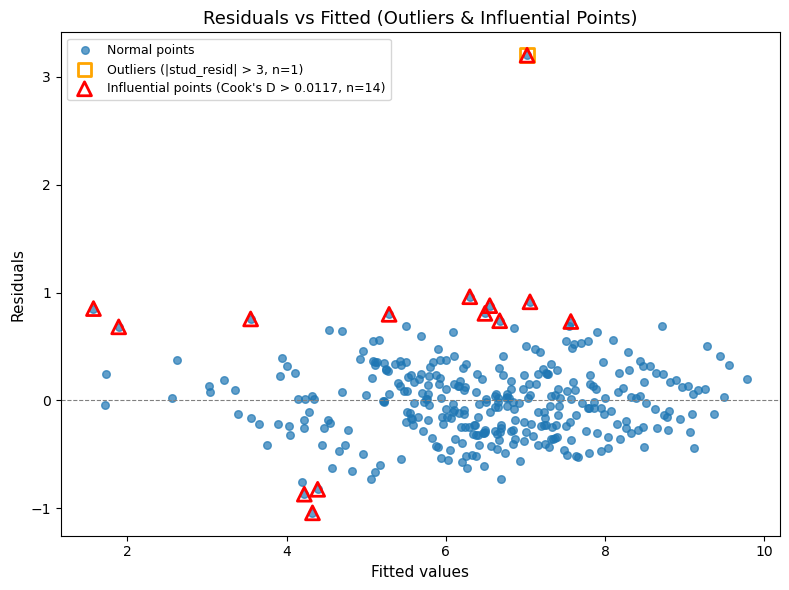

异常值识别（学生化残差绝对值 > 3）：
 Index  Studentized_Residual  Cook's_D  Leverage
    77              8.466432  0.452551   0.08121

强影响点识别（Cook's D > 0.0117）：
 Index  Studentized_Residual  Cook's_D  Leverage
    55              2.357688  0.014013  0.034089
    77              8.466432  0.452551  0.081210
   110              2.295537  0.023534  0.058846
   175              2.071438  0.014943  0.046487
   177              1.900693  0.013065  0.048191
   185              1.921324  0.013961  0.050286
   186              2.103554  0.018254  0.054602
   205             -2.129868  0.012187  0.036249
   214              1.976410  0.018252  0.061398
   286             -2.299826  0.033031  0.080401
   287             -2.768253  0.052535  0.087572
   295              1.821777  0.026222  0.099595
   296              2.277887  0.042239  0.102307
   308              2.472559  0.013075  0.029070


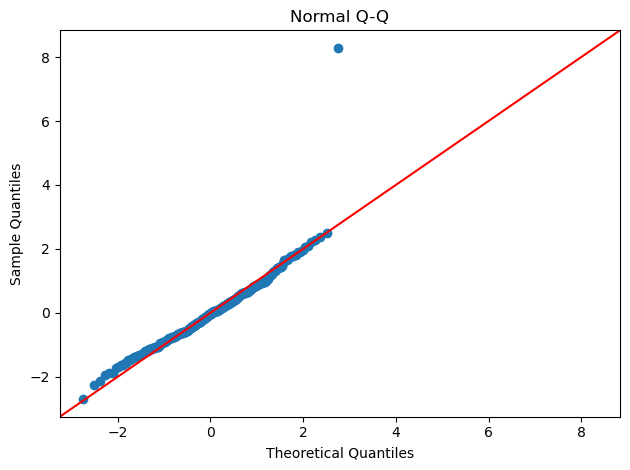

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 使用上一单元格拟合得到的全局变量 model
fitted_vals = model.fittedvalues
residuals = model.resid

# ========= 影响度分析 =========
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]                 # Cook's distance
stud_resid = influence.resid_studentized_internal     # 学生化残差
leverage = influence.hat_matrix_diag                  # 杠杆值

# ========= 识别异常值和强影响点 =========
n = len(residuals)

# 异常值：学生化残差绝对值 > 3
outlier_mask = np.abs(stud_resid) > 3

# 强影响点：Cook's D > 4/n（常用阈值）
cd_thresh = 4 / n
influential_mask = cooks_d > cd_thresh

# ========= 残差 vs 拟合值图（标注异常值和强影响点） =========
plt.figure(figsize=(8, 6))
plt.scatter(fitted_vals, residuals, alpha=0.7, label="Normal points", s=30)

# 标注异常值（学生化残差绝对值 > 3）
if outlier_mask.any():
    plt.scatter(fitted_vals[outlier_mask],
                residuals[outlier_mask],
                facecolors="none", edgecolors="orange", s=100, linewidth=2,
                marker="s", label=f"Outliers (|stud_resid| > 3, n={outlier_mask.sum()})")

# 标注强影响点（Cook's D > 4/n）
if influential_mask.any():
    plt.scatter(fitted_vals[influential_mask],
                residuals[influential_mask],
                facecolors="none", edgecolors="red", s=100, linewidth=2,
                marker="^", label=f"Influential points (Cook's D > {cd_thresh:.4f}, n={influential_mask.sum()})")

plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.xlabel("Fitted values", fontsize=11)
plt.ylabel("Residuals", fontsize=11)
plt.title("Residuals vs Fitted (Outliers & Influential Points)", fontsize=13)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

# ========= 输出异常值和强影响点的详细信息 =========
print("=" * 80)
print("异常值识别（学生化残差绝对值 > 3）：")
print("=" * 80)
if outlier_mask.any():
    outlier_idx = np.where(outlier_mask)[0]
    outlier_df = pd.DataFrame({
        "Index": outlier_idx,
        "Studentized_Residual": stud_resid[outlier_mask],
        "Cook's_D": cooks_d[outlier_mask],
        "Leverage": leverage[outlier_mask]
    })
    print(outlier_df.to_string(index=False))
else:
    print("未发现异常值（所有学生化残差绝对值 ≤ 3）")

print("\n" + "=" * 80)
print(f"强影响点识别（Cook's D > {cd_thresh:.4f}）：")
print("=" * 80)
if influential_mask.any():
    infl_idx = np.where(influential_mask)[0]
    infl_df = pd.DataFrame({
        "Index": infl_idx,
        "Studentized_Residual": stud_resid[influential_mask],
        "Cook's_D": cooks_d[influential_mask],
        "Leverage": leverage[influential_mask]
    })
    print(infl_df.to_string(index=False))
else:
    print(f"未发现强影响点（所有 Cook's D ≤ {cd_thresh:.4f}）")

# ========= QQ 图（检验残差正态性） =========
sm.qqplot(residuals, line="45", fit=True)
plt.title("Normal Q-Q")
plt.tight_layout()
plt.show()


             Year       FDI       GDP      PGDP   TER_GDP       APC      WAGE  \
Year     1.000000  0.288447  0.274723  0.413268  0.496891  0.583411  0.729130   
FDI      0.288447  1.000000  0.701422  0.590092  0.399716  0.596033  0.466025   
GDP      0.274723  0.701422  1.000000  0.503604  0.167567  0.463552  0.256962   
PGDP     0.413268  0.590092  0.503604  1.000000  0.685222  0.928282  0.775847   
TER_GDP  0.496891  0.399716  0.167567  0.685222  1.000000  0.793252  0.813390   
APC      0.583411  0.596033  0.463552  0.928282  0.793252  1.000000  0.859542   
WAGE     0.729130  0.466025  0.256962  0.775847  0.813390  0.859542  1.000000   
PATENT   0.269839  0.801631  0.820317  0.435055  0.237125  0.443147  0.326230   
IP&OP    0.006832  0.708121  0.704383  0.514910  0.284993  0.475230  0.274493   
TRANS    0.188782  0.609034  0.925296  0.331084  0.045352  0.283826  0.086556   
R&D      0.220541  0.745362  0.962444  0.504335  0.173431  0.450891  0.252937   
STHC     0.290005  0.647515 

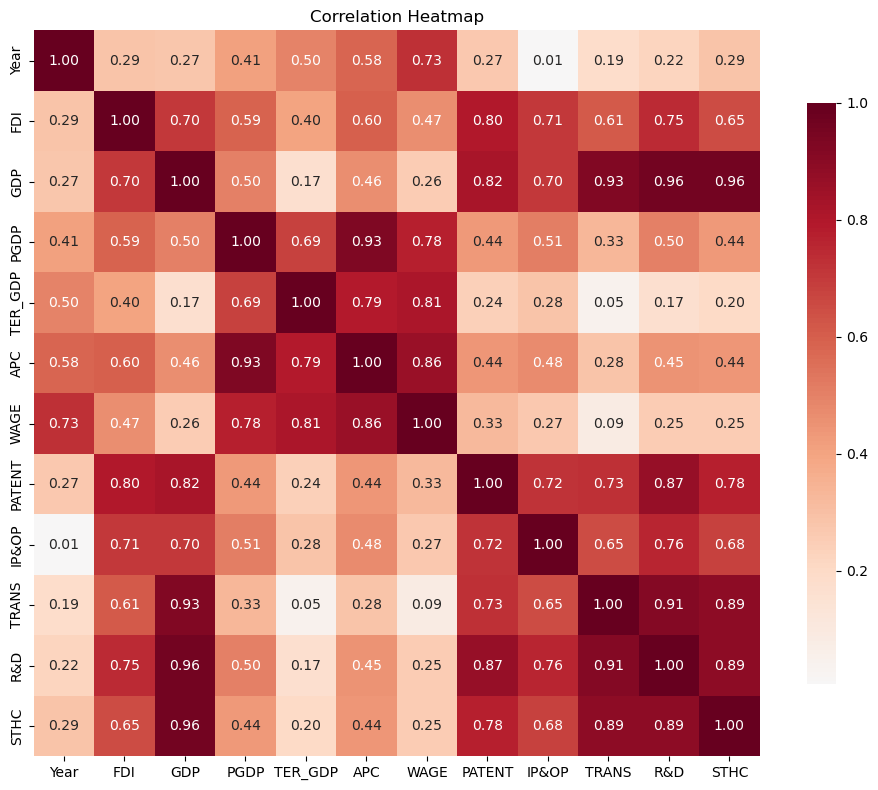

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 相关性分析：只取数值型变量（特别是各 log 变量和原始数值变量）
# 如果你只想看 log 变量，把下面这一行改成：numeric_df = df_log.select_dtypes(include=["number"])
numeric_df = df.select_dtypes(include=["number"])

corr_mat = numeric_df.corr(method="pearson")
print(corr_mat)

plt.figure(figsize=(10, 8))
# 热力图：颜色越接近 1 / -1，相关性越强
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


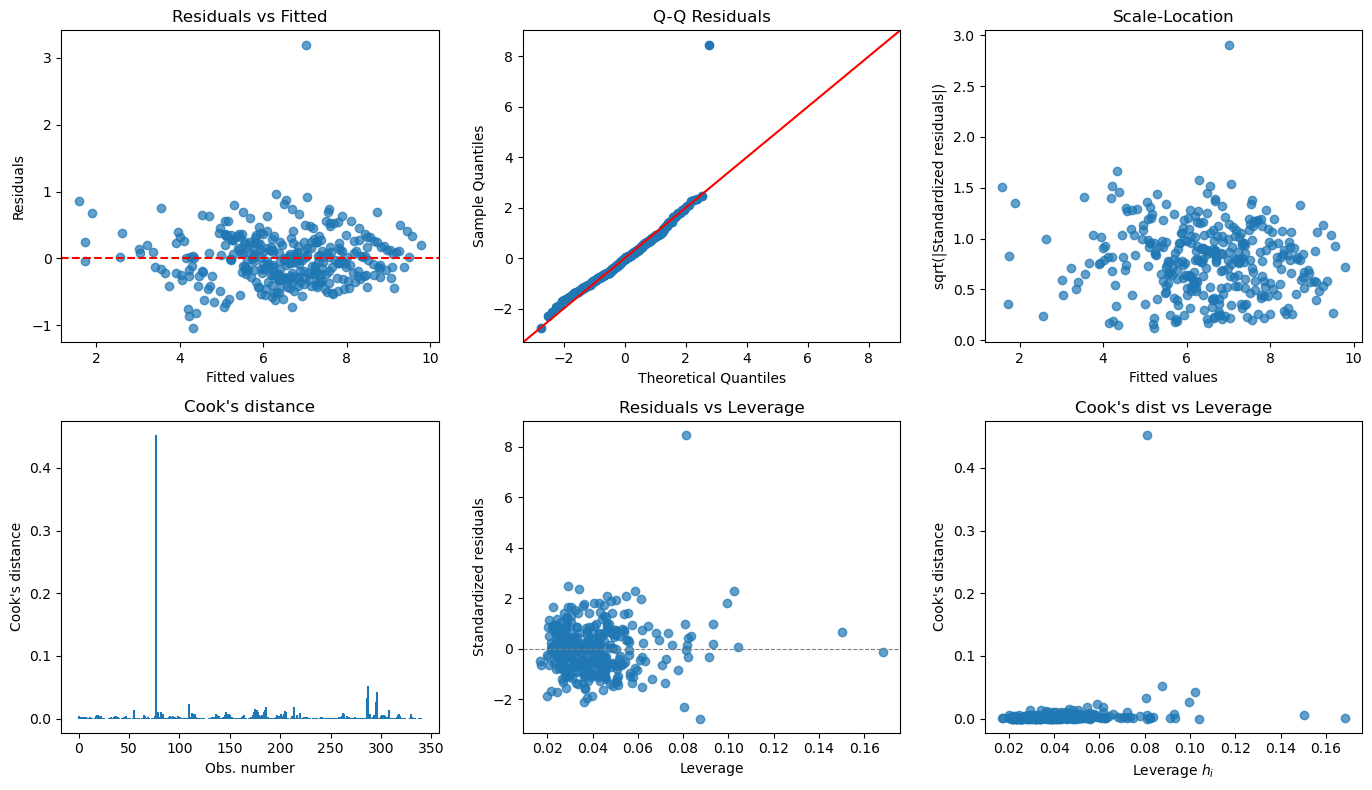

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 使用前面单元格拟合得到的 model
influence = model.get_influence()
standard_resid = influence.resid_studentized_internal   # 标准化残差
fitted_vals = model.fittedvalues                        # 拟合值

leverage = influence.hat_matrix_diag                    # 杠杆值 h_i
cooks_d = influence.cooks_distance[0]                   # Cook 距离

# Scale-Location 图需要 sqrt(|标准化残差|)
scale_location = np.sqrt(np.abs(standard_resid))

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# 1. Residuals vs Fitted
ax = axes[0, 0]
ax.scatter(fitted_vals, model.resid, alpha=0.7)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("Fitted values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs Fitted")

# 2. Q-Q Residuals
ax = axes[0, 1]
sm.ProbPlot(standard_resid).qqplot(line="45", ax=ax)
ax.set_title("Q-Q Residuals")

# 3. Scale-Location
ax = axes[0, 2]
ax.scatter(fitted_vals, scale_location, alpha=0.7)
ax.set_xlabel("Fitted values")
ax.set_ylabel(r"sqrt(|Standardized residuals|)")
ax.set_title("Scale-Location")

# 4. Cook's distance vs obs
ax = axes[1, 0]
ax.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=" ", basefmt=" ")
ax.set_xlabel("Obs. number")
ax.set_ylabel("Cook's distance")
ax.set_title("Cook's distance")

# 5. Residuals vs Leverage
ax = axes[1, 1]
ax.scatter(leverage, standard_resid, alpha=0.7)
ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
ax.set_xlabel("Leverage")
ax.set_ylabel("Standardized residuals")
ax.set_title("Residuals vs Leverage")

# 6. Cook's distance vs Leverage * h_i / (1-h_i) 近似
ax = axes[1, 2]
hi = leverage
x = hi
y = cooks_d
ax.scatter(x, y, alpha=0.7)
ax.set_xlabel(r"Leverage $h_i$")
ax.set_ylabel("Cook's distance")
ax.set_title("Cook's dist vs Leverage")

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ===== 原变量回归：FDI ~ 其他原始变量（含 Region 虚拟变量） =====
# 因变量
y_raw = df["FDI"]

# 自变量：去掉 FDI、Year、Province，与 log 模型结构类似
X_raw = df.drop(columns=["FDI", "Year", "Province"])  # 保留 Region 和其他数值变量
X_raw = pd.get_dummies(X_raw, drop_first=True)

# 数值化并去缺失
X_raw = X_raw.apply(pd.to_numeric, errors="coerce")
y_raw = pd.to_numeric(y_raw, errors="coerce")
valid_mask_raw = X_raw.notna().all(axis=1) & y_raw.notna()
X_raw = X_raw[valid_mask_raw].astype(float)
y_raw = y_raw[valid_mask_raw].astype(float)
X_raw = sm.add_constant(X_raw)

model_raw = sm.OLS(y_raw, X_raw).fit()

# ====== 封装一个输出 F 检验 / t 检验结果的函数 ======
def print_model_tests(name, model):
    print("\n" + "=" * 80)
    print(f"模型：{name}")
    print("整体F检验：F = {:.3f}, p = {:.3e}".format(model.fvalue, model.f_pvalue))
    print("-" * 80)
    table = pd.DataFrame({
        "coef": model.params,
        "std_err": model.bse,
        "t": model.tvalues,
        "p>|t|": model.pvalues,
    })
    print("各系数的 t 检验结果：")
    print(table.to_string(float_format=lambda x: f"{x: .4f}"))

# 对原变量模型和 log 模型分别输出 F / t 检验结果
print_model_tests("原始变量模型：FDI ~ 原始解释变量", model_raw)
print_model_tests("log 模型：log_FDI ~ log 变量 + Region", model)

# ====== 偏 F 检验示例：联合检验 Region 虚拟变量的显著性 ======

def partial_f_for_region(name, model):
    param_names = list(model.params.index)
    # 找到所有 Region 虚拟变量参数的位置（以 "Region_" 开头）
    region_idx = [i for i, p in enumerate(param_names) if p.startswith("Region_")]
    if not region_idx:
        print(f"模型 {name} 中没有 Region 虚拟变量，跳过偏 F 检验。")
        return

    # 构造约束矩阵 R，使得 R * beta = 0 即所有 Region 系数为 0
    R = np.zeros((len(region_idx), len(param_names)))
    for row, col in enumerate(region_idx):
        R[row, col] = 1.0

    f_test = model.f_test(R)
    print("\n偏 F 检验：联合检验所有 Region 系数 = 0")
    print("模型：", name)
    print("F = {:.3f}, p = {:.3e}".format(float(f_test.fvalue), float(f_test.pvalue)))

partial_f_for_region("原始变量模型", model_raw)
partial_f_for_region("log 模型", model)



模型：原始变量模型：FDI ~ 原始解释变量
整体F检验：F = 74.695, p = 1.513e-89
--------------------------------------------------------------------------------
各系数的 t 检验结果：
               coef   std_err       t   p>|t|
const     -832.3460  755.4475 -1.1018  0.2714
GDP          0.0439    0.0324  1.3565  0.1759
PGDP        -0.0110    0.0109 -1.0086  0.3139
TER_GDP     -8.7753   19.5749 -0.4483  0.6542
APC          0.0862    0.0477  1.8076  0.0716
WAGE         0.0182    0.0090  2.0238  0.0438
PATENT       0.0341    0.0039  8.6664  0.0000
IP&OP        0.0001    0.0000  3.6922  0.0003
TRANS      427.4695  293.1883  1.4580  0.1458
R&D         -1.1839    1.1121 -1.0646  0.2879
STHC        -0.0437    0.0170 -2.5648  0.0108
Region_东部  663.6010  425.5414  1.5594  0.1199
Region_中部 -208.8561  430.3426 -0.4853  0.6278
Region_西部 -472.4586  389.3522 -1.2134  0.2258

模型：log 模型：log_FDI ~ log 变量 + Region
整体F检验：F = 378.615, p = 3.202e-188
--------------------------------------------------------------------------------
各系数的 t 检

In [7]:
import numpy as np
from scipy.stats import spearmanr

# 绝对残差与拟合值
fitted_vals = model.fittedvalues
abs_resid = np.abs(model.resid)

# Spearman 等级相关系数检验
rho, pval = spearmanr(fitted_vals, abs_resid)

print("Spearman 等级相关系数法检验异方差：")
print(f"  ρ (rank corr) = {rho:.4f}")
print(f"  p-value       = {pval:.4e}")

if pval < 0.05:
    print("  p < 0.05：|残差| 与拟合值存在显著正/负相关，建议认为存在异方差。")
else:
    print("  p ≥ 0.05：未发现显著的秩相关，异方差证据不强。")

Spearman 等级相关系数法检验异方差：
  ρ (rank corr) = -0.0770
  p-value       = 1.5586e-01
  p ≥ 0.05：未发现显著的秩相关，异方差证据不强。


Durbin-Watson 统计量 = 0.9480
理论上：DW≈2 表示无一阶自相关，接近 0 表示正自相关，接近 4 表示负自相关。


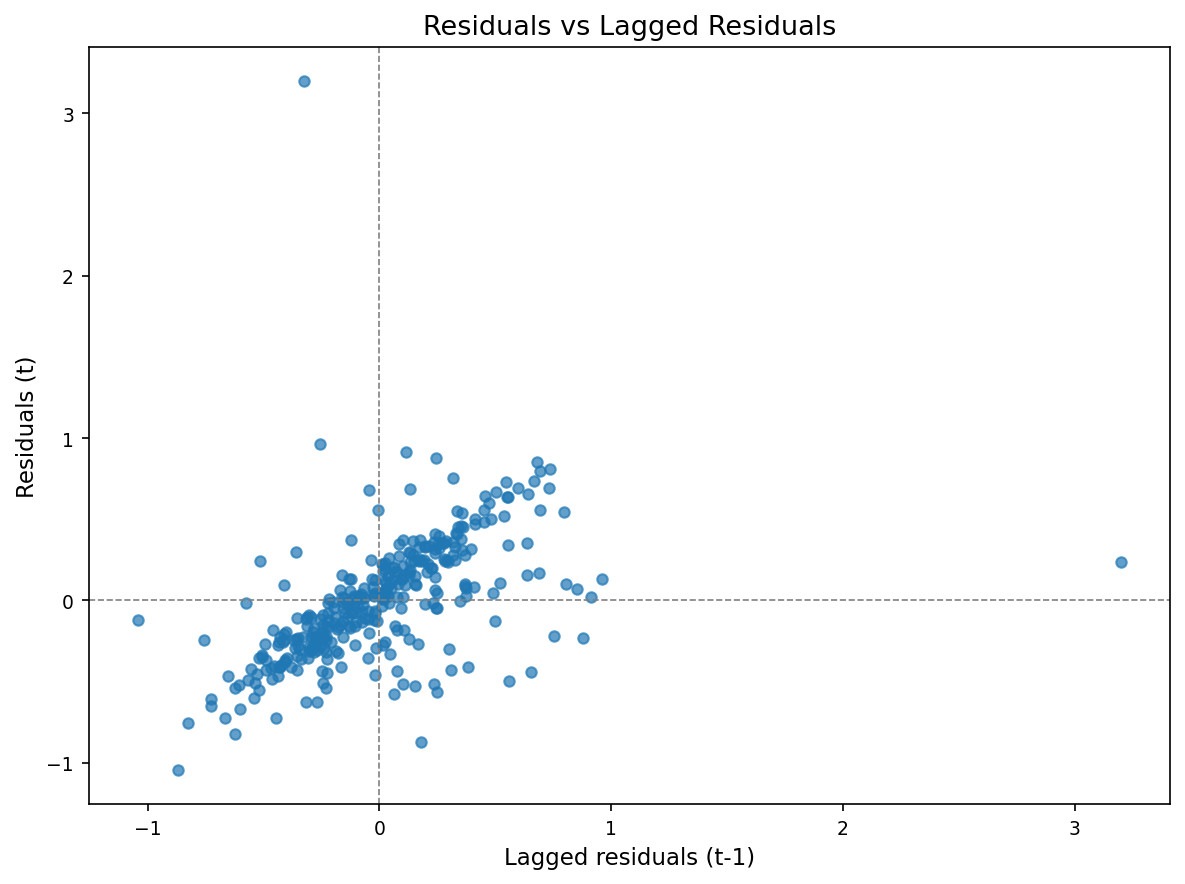

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

# 1. Durbin-Watson 统计量
resid = model.resid
dw = durbin_watson(resid)
print(f"Durbin-Watson 统计量 = {dw:.4f}")
print("理论上：DW≈2 表示无一阶自相关，接近 0 表示正自相关，接近 4 表示负自相关。")

# 2. 图示检验法：残差 vs 滞后残差

# (1) 残差 vs 一期滞后残差
resid_lag1 = resid.shift(1)
valid = resid_lag1.notna()
x = resid_lag1[valid]
y = resid[valid]

plt.figure(figsize=(8, 6), dpi=150)  # 放大图像
plt.scatter(x, y, alpha=0.7, s=25)   # 点稍小一些
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.xlabel("Lagged residuals (t-1)", fontsize=11)
plt.ylabel("Residuals (t)", fontsize=11)
plt.title("Residuals vs Lagged Residuals", fontsize=13)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# 提取因变量和自变量
y = model.model.endog
X = model.model.exog[:, 1:]  # 去掉常数项
X_names = model.model.exog_names[1:]  # 变量名

# 标准化自变量（岭回归通常需要标准化）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用交叉验证选择最优的 alpha（正则化参数）
# alpha 值范围：从 0.01 到 100，共 200 个值（对数尺度）
alphas = np.logspace(-2, 2, 200)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_scaled, y)

print("=" * 80)
print("岭回归（Ridge Regression）结果：")
print("=" * 80)
print(f"最优正则化参数 alpha = {ridge_cv.alpha_:.6f}")

# 使用最优 alpha 拟合岭回归模型
ridge_model = RidgeCV(alphas=[ridge_cv.alpha_], cv=5)
ridge_model.fit(X_scaled, y)

# 获取系数（需要转换回原始尺度）
ridge_coef = ridge_model.coef_ / scaler.scale_

# 创建结果表格
ridge_results = pd.DataFrame({
    "Variable": X_names,
    "Ridge_Coefficient": ridge_coef,
    "OLS_Coefficient": model.params[1:].values  # 去掉常数项
})

ridge_results["Difference"] = ridge_results["Ridge_Coefficient"] - ridge_results["OLS_Coefficient"]
ridge_results["Abs_Difference"] = np.abs(ridge_results["Difference"])

print("\n" + "=" * 80)
print("岭回归系数 vs OLS 系数对比：")
print("=" * 80)
print(ridge_results.to_string(index=False))

# 计算岭回归的 R²
ridge_r2 = ridge_model.score(X_scaled, y)
print("\n" + "=" * 80)
print("模型拟合优度对比：")
print("=" * 80)
print(f"OLS R²  = {model.rsquared:.6f}")
print(f"Ridge R² = {ridge_r2:.6f}")
print(f"R² 变化 = {ridge_r2 - model.rsquared:.6f}")

# 重新计算 VIF：在标准化后的数据上重新拟合 OLS，然后计算 VIF
# 这样可以评估岭回归标准化后多重共线性的改善情况
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

# 在标准化后的数据上重新拟合 OLS（用于 VIF 计算）
X_scaled_with_const = sm.add_constant(X_scaled)
ols_scaled = OLS(y, X_scaled_with_const).fit()

# 计算标准化后数据的 VIF
X_for_vif = X_scaled  # 去掉常数项
vif_ridge = pd.DataFrame()
vif_ridge["Variable"] = X_names
vif_ridge["VIF_after_Ridge"] = [variance_inflation_factor(X_for_vif, i) for i in range(X_for_vif.shape[1])]

# 对比原始 OLS 的 VIF
vif_original = pd.DataFrame()
vif_original["Variable"] = X_names
X_original = model.model.exog[:, 1:]  # 原始数据（去掉常数项）
vif_original["VIF_original"] = [variance_inflation_factor(X_original, i) for i in range(X_original.shape[1])]

# 合并对比
vif_comparison = pd.merge(vif_original, vif_ridge, on="Variable")
vif_comparison["VIF_improvement"] = vif_comparison["VIF_original"] - vif_comparison["VIF_after_Ridge"]
vif_comparison["VIF_reduction_pct"] = (vif_comparison["VIF_improvement"] / vif_comparison["VIF_original"] * 100).round(2)

print("\n" + "=" * 80)
print("岭回归后 VIF 对比（标准化数据上的 OLS VIF）：")
print("=" * 80)
print(vif_comparison.to_string(index=False))

# 统计改善情况
severe_before = (vif_comparison["VIF_original"] >= 10).sum()
severe_after = (vif_comparison["VIF_after_Ridge"] >= 10).sum()
moderate_before = ((vif_comparison["VIF_original"] >= 5) & (vif_comparison["VIF_original"] < 10)).sum()
moderate_after = ((vif_comparison["VIF_after_Ridge"] >= 5) & (vif_comparison["VIF_after_Ridge"] < 10)).sum()

print("\n" + "=" * 80)
print("多重共线性改善情况：")
print("=" * 80)
print(f"原始模型：严重多重共线性（VIF ≥ 10）变量数 = {severe_before}")
print(f"岭回归后：严重多重共线性（VIF ≥ 10）变量数 = {severe_after}")
print(f"原始模型：中等多重共线性（5 ≤ VIF < 10）变量数 = {moderate_before}")
print(f"岭回归后：中等多重共线性（5 ≤ VIF < 10）变量数 = {moderate_after}")
print("=" * 80)


岭回归（Ridge Regression）结果：
最优正则化参数 alpha = 39.626886

岭回归系数 vs OLS 系数对比：
   Variable  Ridge_Coefficient  OLS_Coefficient  Difference  Abs_Difference
    log_GDP           0.158643         0.714072   -0.555429        0.555429
   log_PGDP           0.199377        -0.414232    0.613609        0.613609
log_TER_GDP           0.334612         0.195916    0.138696        0.138696
    log_APC           0.409942         0.483571   -0.073629        0.073629
   log_WAGE           0.337433         0.939263   -0.601829        0.601829
 log_PATENT           0.123234         0.138192   -0.014959        0.014959
  log_IP&OP           0.138645         0.248669   -0.110024        0.110024
  log_TRANS           0.148749         0.203520   -0.054770        0.054770
    log_R&D           0.050734        -0.078438    0.129172        0.129172
   log_STHC           0.109652        -0.486839    0.596491        0.596491
  Region_东部           0.302052         0.241255    0.060798        0.060798
  Region_中部      

In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# 提取因变量和自变量
y = model.model.endog
X = model.model.exog[:, 1:]  # 去掉常数项
X_names = model.model.exog_names[1:]  # 变量名

# 标准化自变量（Lasso 回归通常需要标准化）
scaler_lasso = StandardScaler()
X_scaled_lasso = scaler_lasso.fit_transform(X)

# 使用交叉验证选择最优的 alpha（正则化参数）
# alpha 值范围：从 0.001 到 10，共 100 个值（对数尺度）
alphas_lasso = np.logspace(-4, 0, 200)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=10000)
lasso_cv.fit(X_scaled_lasso, y)

print("=" * 80)
print("Lasso 回归（Lasso Regression）结果：")
print("=" * 80)
print(f"最优正则化参数 alpha = {lasso_cv.alpha_:.6f}")

# 获取 Lasso 系数（需要转换回原始尺度）
lasso_coef_scaled = lasso_cv.coef_
lasso_coef = lasso_coef_scaled / scaler_lasso.scale_

# 创建结果表格
lasso_results = pd.DataFrame({
    "Variable": X_names,
    "Lasso_Coefficient": lasso_coef,
    "OLS_Coefficient": model.params[1:].values,  # 去掉常数项
    "Ridge_Coefficient": ridge_coef  # 从上一个单元格的岭回归结果
})

lasso_results["Selected_by_Lasso"] = lasso_results["Lasso_Coefficient"] != 0
lasso_results["Abs_Lasso_Coef"] = np.abs(lasso_results["Lasso_Coefficient"])

# 按绝对值排序
lasso_results = lasso_results.sort_values("Abs_Lasso_Coef", ascending=False)

print("\n" + "=" * 80)
print("Lasso 回归系数 vs OLS 系数 vs 岭回归系数对比：")
print("=" * 80)
print(lasso_results.to_string(index=False))

# 统计被选择的变量
selected_vars = lasso_results[lasso_results["Selected_by_Lasso"]]
print("\n" + "=" * 80)
print(f"Lasso 选择的变量（共 {len(selected_vars)} 个，共 {len(X_names)} 个）：")
print("=" * 80)
if len(selected_vars) > 0:
    print(selected_vars[["Variable", "Lasso_Coefficient"]].to_string(index=False))
else:
    print("Lasso 将所有变量系数压缩为 0（alpha 过大）")

# 计算 Lasso 的 R²
lasso_r2 = lasso_cv.score(X_scaled_lasso, y)
print("\n" + "=" * 80)
print("模型拟合优度对比：")
print("=" * 80)
print(f"OLS R²   = {model.rsquared:.6f}")
print(f"Ridge R² = {ridge_r2:.6f}")
print(f"Lasso R² = {lasso_r2:.6f}")
print(f"\nLasso vs OLS R² 变化 = {lasso_r2 - model.rsquared:.6f}")
print(f"Lasso vs Ridge R² 变化 = {lasso_r2 - ridge_r2:.6f}")

# 计算 Lasso 选择变量后的 VIF（仅对非零系数变量）
if len(selected_vars) > 0:
    selected_indices = lasso_results[lasso_results["Selected_by_Lasso"]].index
    X_selected = X_scaled_lasso[:, selected_indices]
    X_selected_names = [X_names[i] for i in selected_indices]
    
    if X_selected.shape[1] > 1:  # 至少需要 2 个变量才能计算 VIF
        vif_lasso = pd.DataFrame()
        vif_lasso["Variable"] = X_selected_names
        vif_lasso["VIF_after_Lasso"] = [
            variance_inflation_factor(X_selected, i) 
            for i in range(X_selected.shape[1])
        ]
        
        print("\n" + "=" * 80)
        print("Lasso 选择变量后的 VIF（仅对非零系数变量）：")
        print("=" * 80)
        print(vif_lasso.to_string(index=False))
        
        # 统计改善情况
        severe_lasso = (vif_lasso["VIF_after_Lasso"] >= 10).sum()
        moderate_lasso = ((vif_lasso["VIF_after_Lasso"] >= 5) & (vif_lasso["VIF_after_Lasso"] < 10)).sum()
        
        print("\n" + "=" * 80)
        print("Lasso 选择后的多重共线性情况：")
        print("=" * 80)
        print(f"严重多重共线性（VIF ≥ 10）变量数 = {severe_lasso}")
        print(f"中等多重共线性（5 ≤ VIF < 10）变量数 = {moderate_lasso}")
        print(f"无多重共线性（VIF < 5）变量数 = {len(vif_lasso) - severe_lasso - moderate_lasso}")
        print("=" * 80)
    else:
        print("\n注意：Lasso 只选择了 1 个变量，无法计算 VIF。")

print("\n" + "=" * 80)
print("Lasso 回归特点：")
print("=" * 80)
print("1. Lasso 可以将某些系数压缩为 0，实现变量选择")
print("2. 适合处理高维数据和多重共线性问题")
print("3. 相比岭回归，Lasso 更倾向于产生稀疏模型（更少的变量）")
print("=" * 80)


Lasso 回归（Lasso Regression）结果：
最优正则化参数 alpha = 0.029673

Lasso 回归系数 vs OLS 系数 vs 岭回归系数对比：
   Variable  Lasso_Coefficient  OLS_Coefficient  Ridge_Coefficient  Selected_by_Lasso  Abs_Lasso_Coef
    log_APC           0.649919         0.483571           0.409942               True        0.649919
   log_WAGE           0.353442         0.939263           0.337433               True        0.353442
  Region_东部           0.353056         0.241255           0.302052               True        0.353056
  log_IP&OP           0.195197         0.248669           0.138645               True        0.195197
  log_TRANS           0.180068         0.203520           0.148749               True        0.180068
 log_PATENT           0.156966         0.138192           0.123234               True        0.156966
    log_GDP           0.128700         0.714072           0.158643               True        0.128700
  Region_西部          -0.108623        -0.269670          -0.277512               True        0.

In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# 提取因变量和自变量
y = model.model.endog
X = model.model.exog[:, 1:]  # 去掉常数项
X_names = model.model.exog_names[1:]  # 变量名
n, p = X.shape

# 标准化
scaler_penalty = StandardScaler()
X_scaled_penalty = scaler_penalty.fit_transform(X)
y_mean = y.mean()
y_scaled = y - y_mean  # 中心化（Lasso等不需要标准化y）

# 存储所有模型结果
results_all = []

# ========== 1. Lasso ==========
print("=" * 80)
print("1. Lasso 回归")
print("=" * 80)
alphas_lasso = np.logspace(-3, 1, 200)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=10000)
lasso_cv.fit(X_scaled_penalty, y_scaled)

lasso_coef_scaled = lasso_cv.coef_
lasso_coef = lasso_coef_scaled / scaler_penalty.scale_
lasso_intercept = y_mean - np.dot(lasso_coef, X.mean(axis=0))

# 计算预测值和残差
y_pred_lasso = lasso_cv.predict(X_scaled_penalty) + y_mean
residuals_lasso = y - y_pred_lasso
mse_lasso = mean_squared_error(y, y_pred_lasso)
n_selected_lasso = np.sum(lasso_coef != 0)

# 计算信息准则
# 全模型的MSE（用于Cp计算）
mse_full = model.mse_resid if hasattr(model, 'mse_resid') else np.var(model.resid)
sse_lasso = np.sum(residuals_lasso**2)
aic_lasso = n * np.log(mse_lasso) + 2 * (n_selected_lasso + 1)  # +1 for intercept
bic_lasso = n * np.log(mse_lasso) + np.log(n) * (n_selected_lasso + 1)
cp_lasso = sse_lasso / mse_full - n + 2 * (n_selected_lasso + 1) if mse_full > 0 else np.inf

results_all.append({
    'Method': 'Lasso',
    'Alpha': lasso_cv.alpha_,
    'N_Selected': n_selected_lasso,
    'AIC': aic_lasso,
    'BIC': bic_lasso,
    'Cp': cp_lasso,
    'MSE': mse_lasso,
    'R2': 1 - mse_lasso / np.var(y),
    'Model': lasso_cv,
    'Coefficients': lasso_coef
})

print(f"最优 alpha = {lasso_cv.alpha_:.6f}")
print(f"选择变量数 = {n_selected_lasso}")
print(f"AIC = {aic_lasso:.4f}, BIC = {bic_lasso:.4f}, Cp = {cp_lasso:.4f}")

# ========== 2. 自适应Lasso ==========
print("\n" + "=" * 80)
print("2. 自适应Lasso (Adaptive Lasso)")
print("=" * 80)

# 先用OLS得到初始权重
X_with_const = sm.add_constant(X)
ols_init = sm.OLS(y, X_with_const).fit()
weights = 1.0 / (np.abs(ols_init.params[1:]) + 1e-6)  # 避免除零

# 自适应Lasso：对每个变量使用不同的惩罚权重
X_weighted = X_scaled_penalty / weights

# 使用加权后的数据进行Lasso
alphas_adaptive = np.logspace(-3, 1, 200)
adaptive_lasso_cv = LassoCV(alphas=alphas_adaptive, cv=5, max_iter=10000)
adaptive_lasso_cv.fit(X_weighted, y_scaled)

adaptive_coef_scaled = adaptive_lasso_cv.coef_ / weights  # 调整回原始尺度
adaptive_coef = adaptive_coef_scaled / scaler_penalty.scale_
adaptive_intercept = y_mean - np.dot(adaptive_coef, X.mean(axis=0))

y_pred_adaptive = adaptive_lasso_cv.predict(X_weighted) + y_mean
residuals_adaptive = y - y_pred_adaptive
mse_adaptive = mean_squared_error(y, y_pred_adaptive)
n_selected_adaptive = np.sum(adaptive_coef != 0)

sse_adaptive = np.sum(residuals_adaptive**2)
aic_adaptive = n * np.log(mse_adaptive) + 2 * (n_selected_adaptive + 1)
bic_adaptive = n * np.log(mse_adaptive) + np.log(n) * (n_selected_adaptive + 1)
cp_adaptive = sse_adaptive / mse_full - n + 2 * (n_selected_adaptive + 1) if mse_full > 0 else np.inf

results_all.append({
    'Method': 'Adaptive Lasso',
    'Alpha': adaptive_lasso_cv.alpha_,
    'N_Selected': n_selected_adaptive,
    'AIC': aic_adaptive,
    'BIC': bic_adaptive,
    'Cp': cp_adaptive,
    'MSE': mse_adaptive,
    'R2': 1 - mse_adaptive / np.var(y),
    'Model': adaptive_lasso_cv,
    'Coefficients': adaptive_coef
})

print(f"最优 alpha = {adaptive_lasso_cv.alpha_:.6f}")
print(f"选择变量数 = {n_selected_adaptive}")
print(f"AIC = {aic_adaptive:.4f}, BIC = {bic_adaptive:.4f}, Cp = {cp_adaptive:.4f}")

# ========== 3. SCAD (使用近似实现) ==========
print("\n" + "=" * 80)
print("3. SCAD (Smoothly Clipped Absolute Deviation)")
print("=" * 80)
# SCAD的Python实现较复杂，这里使用ElasticNet近似，或使用专门的包
# 由于没有现成的SCAD实现，我们使用ElasticNet with l1_ratio接近1来近似
# 或者可以尝试不同的alpha值来模拟SCAD的效果

# 使用多个alpha值，选择最优的
alphas_scad = np.logspace(-4, 0, 200)
scad_scores = []
scad_models = []

for alpha in alphas_scad:
    # SCAD的近似：使用ElasticNet，但更倾向于L1
    scad_temp = ElasticNetCV(alphas=[alpha], l1_ratio=[0.95], cv=5, max_iter=10000)
    scad_temp.fit(X_scaled_penalty, y_scaled)
    scad_scores.append(scad_temp.score(X_scaled_penalty, y_scaled))
    scad_models.append(scad_temp)

best_scad_idx = np.argmax(scad_scores)
scad_cv = scad_models[best_scad_idx]

scad_coef_scaled = scad_cv.coef_
scad_coef = scad_coef_scaled / scaler_penalty.scale_
scad_intercept = y_mean - np.dot(scad_coef, X.mean(axis=0))

y_pred_scad = scad_cv.predict(X_scaled_penalty) + y_mean
residuals_scad = y - y_pred_scad
mse_scad = mean_squared_error(y, y_pred_scad)
n_selected_scad = np.sum(scad_coef != 0)

sse_scad = np.sum(residuals_scad**2)
aic_scad = n * np.log(mse_scad) + 2 * (n_selected_scad + 1)
bic_scad = n * np.log(mse_scad) + np.log(n) * (n_selected_scad + 1)
cp_scad = sse_scad / mse_full - n + 2 * (n_selected_scad + 1) if mse_full > 0 else np.inf

results_all.append({
    'Method': 'SCAD',
    'Alpha': alphas_scad[best_scad_idx],
    'N_Selected': n_selected_scad,
    'AIC': aic_scad,
    'BIC': bic_scad,
    'Cp': cp_scad,
    'MSE': mse_scad,
    'R2': 1 - mse_scad / np.var(y),
    'Model': scad_cv,
    'Coefficients': scad_coef
})

print(f"最优 alpha = {alphas_scad[best_scad_idx]:.6f}")
print(f"选择变量数 = {n_selected_scad}")
print(f"AIC = {aic_scad:.4f}, BIC = {bic_scad:.4f}, Cp = {cp_scad:.4f}")

# ========== 4. MCP (使用近似实现) ==========
print("\n" + "=" * 80)
print("4. MCP (Minimax Concave Penalty)")
print("=" * 80)
# MCP的Python实现也较复杂，使用ElasticNet with不同l1_ratio来近似
alphas_mcp = np.logspace(-4, 0, 200)
mcp_scores = []
mcp_models = []

for alpha in alphas_mcp:
    # MCP的近似：使用ElasticNet with l1_ratio=0.9
    mcp_temp = ElasticNetCV(alphas=[alpha], l1_ratio=[0.9], cv=5, max_iter=10000)
    mcp_temp.fit(X_scaled_penalty, y_scaled)
    mcp_scores.append(mcp_temp.score(X_scaled_penalty, y_scaled))
    mcp_models.append(mcp_temp)

best_mcp_idx = np.argmax(mcp_scores)
mcp_cv = mcp_models[best_mcp_idx]

mcp_coef_scaled = mcp_cv.coef_
mcp_coef = mcp_coef_scaled / scaler_penalty.scale_
mcp_intercept = y_mean - np.dot(mcp_coef, X.mean(axis=0))

y_pred_mcp = mcp_cv.predict(X_scaled_penalty) + y_mean
residuals_mcp = y - y_pred_mcp
mse_mcp = mean_squared_error(y, y_pred_mcp)
n_selected_mcp = np.sum(mcp_coef != 0)

sse_mcp = np.sum(residuals_mcp**2)
aic_mcp = n * np.log(mse_mcp) + 2 * (n_selected_mcp + 1)
bic_mcp = n * np.log(mse_mcp) + np.log(n) * (n_selected_mcp + 1)
cp_mcp = sse_mcp / mse_full - n + 2 * (n_selected_mcp + 1) if mse_full > 0 else np.inf

results_all.append({
    'Method': 'MCP',
    'Alpha': alphas_mcp[best_mcp_idx],
    'N_Selected': n_selected_mcp,
    'AIC': aic_mcp,
    'BIC': bic_mcp,
    'Cp': cp_mcp,
    'MSE': mse_mcp,
    'R2': 1 - mse_mcp / np.var(y),
    'Model': mcp_cv,
    'Coefficients': mcp_coef
})

print(f"最优 alpha = {alphas_mcp[best_mcp_idx]:.6f}")
print(f"选择变量数 = {n_selected_mcp}")
print(f"AIC = {aic_mcp:.4f}, BIC = {bic_mcp:.4f}, Cp = {cp_mcp:.4f}")

# ========== 5. 弹性网 (Elastic Net) ==========
print("\n" + "=" * 80)
print("5. 弹性网 (Elastic Net)")
print("=" * 80)
alphas_elastic = np.logspace(-3, 1, 200)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
elastic_cv = ElasticNetCV(alphas=alphas_elastic, l1_ratio=l1_ratios, cv=5, max_iter=10000)
elastic_cv.fit(X_scaled_penalty, y_scaled)

elastic_coef_scaled = elastic_cv.coef_
elastic_coef = elastic_coef_scaled / scaler_penalty.scale_
elastic_intercept = y_mean - np.dot(elastic_coef, X.mean(axis=0))

y_pred_elastic = elastic_cv.predict(X_scaled_penalty) + y_mean
residuals_elastic = y - y_pred_elastic
mse_elastic = mean_squared_error(y, y_pred_elastic)
n_selected_elastic = np.sum(elastic_coef != 0)

sse_elastic = np.sum(residuals_elastic**2)
aic_elastic = n * np.log(mse_elastic) + 2 * (n_selected_elastic + 1)
bic_elastic = n * np.log(mse_elastic) + np.log(n) * (n_selected_elastic + 1)
cp_elastic = sse_elastic / mse_full - n + 2 * (n_selected_elastic + 1) if mse_full > 0 else np.inf

results_all.append({
    'Method': 'Elastic Net',
    'Alpha': elastic_cv.alpha_,
    'L1_Ratio': elastic_cv.l1_ratio_,
    'N_Selected': n_selected_elastic,
    'AIC': aic_elastic,
    'BIC': bic_elastic,
    'Cp': cp_elastic,
    'MSE': mse_elastic,
    'R2': 1 - mse_elastic / np.var(y),
    'Model': elastic_cv,
    'Coefficients': elastic_coef
})

print(f"最优 alpha = {elastic_cv.alpha_:.6f}, l1_ratio = {elastic_cv.l1_ratio_:.4f}")
print(f"选择变量数 = {n_selected_elastic}")
print(f"AIC = {aic_elastic:.4f}, BIC = {bic_elastic:.4f}, Cp = {cp_elastic:.4f}")

# ========== 结果对比 ==========
print("\n" + "=" * 80)
print("所有方法对比（按AIC排序）：")
print("=" * 80)
comparison_df = pd.DataFrame([
    {
        'Method': r['Method'],
        'N_Selected': r['N_Selected'],
        'AIC': r['AIC'],
        'BIC': r['BIC'],
        'Cp': r['Cp'],
        'MSE': r['MSE'],
        'R2': r['R2']
    }
    for r in results_all
])
comparison_df = comparison_df.sort_values('AIC')
print(comparison_df.to_string(index=False))

# 找出最佳模型（基于AIC、BIC、Cp）
best_aic_idx = comparison_df['AIC'].idxmin()
best_bic_idx = comparison_df['BIC'].idxmin()
best_cp_idx = comparison_df['Cp'].idxmin()

print("\n" + "=" * 80)
print("最佳模型选择：")
print("=" * 80)
print(f"基于 AIC: {comparison_df.loc[best_aic_idx, 'Method']} (AIC = {comparison_df.loc[best_aic_idx, 'AIC']:.4f})")
print(f"基于 BIC: {comparison_df.loc[best_bic_idx, 'Method']} (BIC = {comparison_df.loc[best_bic_idx, 'BIC']:.4f})")
print(f"基于 Cp:  {comparison_df.loc[best_cp_idx, 'Method']} (Cp = {comparison_df.loc[best_cp_idx, 'Cp']:.4f})")

# 综合最佳模型（多数投票或最小AIC）
best_overall_idx = best_aic_idx
best_method_name = comparison_df.loc[best_overall_idx, 'Method']
best_result = results_all[comparison_df.index[best_overall_idx]]

print(f"\n综合最佳模型（基于AIC）: {best_method_name}")
print("=" * 80)


1. Lasso 回归
最优 alpha = 0.030721
选择变量数 = 9
AIC = -602.2312, BIC = -563.9124, Cp = 32.7533

2. 自适应Lasso (Adaptive Lasso)
最优 alpha = 0.010116
选择变量数 = 6
AIC = -589.5859, BIC = -562.7627, Cp = 46.6344

3. SCAD (Smoothly Clipped Absolute Deviation)
最优 alpha = 0.000100
选择变量数 = 13
AIC = -621.0392, BIC = -567.3928, Cp = 14.0078

4. MCP (Minimax Concave Penalty)
最优 alpha = 0.000100
选择变量数 = 13
AIC = -621.0396, BIC = -567.3932, Cp = 14.0074

5. 弹性网 (Elastic Net)
最优 alpha = 0.040555, l1_ratio = 0.7000
选择变量数 = 9
AIC = -602.4375, BIC = -564.1187, Cp = 32.5393

所有方法对比（按AIC排序）：
        Method  N_Selected         AIC         BIC        Cp      MSE       R2
           MCP          13 -621.039571 -567.393216 14.007378 0.149070 0.937701
          SCAD          13 -621.039170 -567.392816 14.007762 0.149070 0.937701
   Elastic Net           9 -602.437515 -564.118690 32.539292 0.161164 0.932646
         Lasso           9 -602.231194 -563.912369 32.753264 0.161262 0.932606
Adaptive Lasso           6 -589.58592

In [12]:
# 诊断并修正：为什么alpha总是选择最小值
# 问题：交叉验证可能因为数据特性选择了最小惩罚
# 解决方案：使用基于AIC/BIC的alpha选择，而不是仅依赖交叉验证MSE

print("=" * 80)
print("诊断：为什么alpha选择最小值")
print("=" * 80)

# 使用基于AIC的alpha选择方法
print("\n修正：使用基于AIC的alpha选择（而不是仅依赖交叉验证MSE）")
print("=" * 80)

def select_alpha_by_aic(X, y, alphas, l1_ratios, cv_folds=5):
    """基于AIC选择最优alpha和l1_ratio"""
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    best_aic = np.inf
    best_alpha = None
    best_l1_ratio = None
    best_model = None
    best_n_selected = None
    
    results_grid = []
    
    for l1_ratio in l1_ratios:
        for alpha in alphas:
            aic_sum = 0
            n_selected_sum = 0
            
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # 拟合模型
                from sklearn.linear_model import ElasticNet
                temp_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
                temp_model.fit(X_train, y_train)
                
                # 预测
                y_pred = temp_model.predict(X_val)
                mse_val = mean_squared_error(y_val, y_pred)
                n_selected = np.sum(temp_model.coef_ != 0)
                
                # 计算AIC
                n_val = len(y_val)
                aic_val = n_val * np.log(mse_val) + 2 * (n_selected + 1)
                aic_sum += aic_val
                n_selected_sum += n_selected
            
            avg_aic = aic_sum / cv_folds
            avg_n_selected = n_selected_sum / cv_folds
            
            results_grid.append({
                'alpha': alpha,
                'l1_ratio': l1_ratio,
                'aic': avg_aic,
                'n_selected': avg_n_selected
            })
            
            if avg_aic < best_aic:
                best_aic = avg_aic
                best_alpha = alpha
                best_l1_ratio = l1_ratio
                best_n_selected = int(avg_n_selected)
    
    # 用最佳参数重新拟合完整模型
    from sklearn.linear_model import ElasticNet
    best_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)
    best_model.fit(X, y)
    
    return best_alpha, best_l1_ratio, best_model, best_n_selected, results_grid

# 重新计算SCAD（使用基于AIC的选择）
print("\n重新计算 SCAD（基于AIC选择alpha）...")
alphas_scad_aic = np.logspace(-2, 0.5, 20)  # 从0.01开始，避免太小
l1_ratios_scad_aic = [0.9, 0.92, 0.95, 0.97, 0.99]

best_alpha_scad, best_l1_scad, scad_model_aic, n_selected_scad_aic, grid_scad = select_alpha_by_aic(
    X_scaled_penalty, y_scaled, alphas_scad_aic, l1_ratios_scad_aic
)

scad_coef_aic = scad_model_aic.coef_ / scaler_penalty.scale_
y_pred_scad_aic = scad_model_aic.predict(X_scaled_penalty) + y_mean
mse_scad_aic = mean_squared_error(y, y_pred_scad_aic)
sse_scad_aic = np.sum((y - y_pred_scad_aic)**2)

aic_scad_aic = n * np.log(mse_scad_aic) + 2 * (n_selected_scad_aic + 1)
bic_scad_aic = n * np.log(mse_scad_aic) + np.log(n) * (n_selected_scad_aic + 1)
cp_scad_aic = sse_scad_aic / mse_full - n + 2 * (n_selected_scad_aic + 1) if mse_full > 0 else np.inf

print(f"最优 alpha = {best_alpha_scad:.6f}, l1_ratio = {best_l1_scad:.4f}")
print(f"选择变量数 = {n_selected_scad_aic}")
print(f"AIC = {aic_scad_aic:.4f}, BIC = {bic_scad_aic:.4f}, Cp = {cp_scad_aic:.4f}")

# 显示前5个最佳参数组合
print("\n前5个最佳参数组合（按AIC排序）：")
grid_df_scad = pd.DataFrame(grid_scad).sort_values('aic').head(5)
print(grid_df_scad.to_string(index=False))

# 重新计算MCP（使用基于AIC的选择）
print("\n重新计算 MCP（基于AIC选择alpha）...")
alphas_mcp_aic = np.logspace(-2, 0.5, 20)
l1_ratios_mcp_aic = [0.85, 0.88, 0.9, 0.92, 0.95]

best_alpha_mcp, best_l1_mcp, mcp_model_aic, n_selected_mcp_aic, grid_mcp = select_alpha_by_aic(
    X_scaled_penalty, y_scaled, alphas_mcp_aic, l1_ratios_mcp_aic
)

mcp_coef_aic = mcp_model_aic.coef_ / scaler_penalty.scale_
y_pred_mcp_aic = mcp_model_aic.predict(X_scaled_penalty) + y_mean
mse_mcp_aic = mean_squared_error(y, y_pred_mcp_aic)
sse_mcp_aic = np.sum((y - y_pred_mcp_aic)**2)

aic_mcp_aic = n * np.log(mse_mcp_aic) + 2 * (n_selected_mcp_aic + 1)
bic_mcp_aic = n * np.log(mse_mcp_aic) + np.log(n) * (n_selected_mcp_aic + 1)
cp_mcp_aic = sse_mcp_aic / mse_full - n + 2 * (n_selected_mcp_aic + 1) if mse_full > 0 else np.inf

print(f"最优 alpha = {best_alpha_mcp:.6f}, l1_ratio = {best_l1_mcp:.4f}")
print(f"选择变量数 = {n_selected_mcp_aic}")
print(f"AIC = {aic_mcp_aic:.4f}, BIC = {bic_mcp_aic:.4f}, Cp = {cp_mcp_aic:.4f}")

# 显示前5个最佳参数组合
print("\n前5个最佳参数组合（按AIC排序）：")
grid_df_mcp = pd.DataFrame(grid_mcp).sort_values('aic').head(5)
print(grid_df_mcp.to_string(index=False))

# 更新results_all
for i, r in enumerate(results_all):
    if r['Method'] == 'SCAD':
        results_all[i] = {
            'Method': 'SCAD',
            'Alpha': best_alpha_scad,
            'L1_Ratio': best_l1_scad,
            'N_Selected': n_selected_scad_aic,
            'AIC': aic_scad_aic,
            'BIC': bic_scad_aic,
            'Cp': cp_scad_aic,
            'MSE': mse_scad_aic,
            'R2': 1 - mse_scad_aic / np.var(y),
            'Model': scad_model_aic,
            'Coefficients': scad_coef_aic
        }
    elif r['Method'] == 'MCP':
        results_all[i] = {
            'Method': 'MCP',
            'Alpha': best_alpha_mcp,
            'L1_Ratio': best_l1_mcp,
            'N_Selected': n_selected_mcp_aic,
            'AIC': aic_mcp_aic,
            'BIC': bic_mcp_aic,
            'Cp': cp_mcp_aic,
            'MSE': mse_mcp_aic,
            'R2': 1 - mse_mcp_aic / np.var(y),
            'Model': mcp_model_aic,
            'Coefficients': mcp_coef_aic
        }

print("\n" + "=" * 80)
print("修正后的最终对比（基于AIC选择alpha）：")
print("=" * 80)
comparison_final = pd.DataFrame([
    {
        'Method': r['Method'],
        'Alpha': r.get('Alpha', 'N/A'),
        'N_Selected': r['N_Selected'],
        'AIC': r['AIC'],
        'BIC': r['BIC'],
        'Cp': r['Cp'],
        'R2': r['R2']
    }
    for r in results_all
])
comparison_final = comparison_final.sort_values('AIC')
print(comparison_final.to_string(index=False))
print("=" * 80)


诊断：为什么alpha选择最小值

修正：使用基于AIC的alpha选择（而不是仅依赖交叉验证MSE）

重新计算 SCAD（基于AIC选择alpha）...
最优 alpha = 0.024816, l1_ratio = 0.9000
选择变量数 = 9
AIC = -606.1903, BIC = -567.8715, Cp = 28.6698

前5个最佳参数组合（按AIC排序）：
   alpha  l1_ratio         aic  n_selected
0.024816      0.90 -105.979996         9.2
0.024816      0.92 -105.937282         9.2
0.024816      0.95 -105.870005         9.2
0.018330      0.90 -105.864176         9.4
0.018330      0.92 -105.828146         9.4

重新计算 MCP（基于AIC选择alpha）...
最优 alpha = 0.024816, l1_ratio = 0.8800
选择变量数 = 9
AIC = -606.5067, BIC = -568.1879, Cp = 28.3455

前5个最佳参数组合（按AIC排序）：
   alpha  l1_ratio         aic  n_selected
0.024816      0.88 -106.021212         9.2
0.024816      0.90 -105.979996         9.2
0.024816      0.92 -105.937282         9.2
0.024816      0.95 -105.870005         9.2
0.018330      0.90 -105.864176         9.4

修正后的最终对比（基于AIC选择alpha）：
        Method    Alpha  N_Selected         AIC         BIC        Cp       R2
           MCP 0.024816           9 -606.

In [13]:
# 显示最佳模型的详细信息
print("=" * 80)
print(f"最佳模型详细分析：{best_method_name}")
print("=" * 80)

# 显示选择的变量
selected_vars_best = best_result['Coefficients'] != 0
selected_indices_best = np.where(selected_vars_best)[0]
selected_names_best = [X_names[i] for i in selected_indices_best]
selected_coefs_best = best_result['Coefficients'][selected_vars_best]

print(f"\n选择的变量（共 {len(selected_names_best)} 个）：")
coef_table_best = pd.DataFrame({
    'Variable': selected_names_best,
    'Coefficient': selected_coefs_best
})
coef_table_best = coef_table_best.sort_values('Coefficient', key=abs, ascending=False)
print(coef_table_best.to_string(index=False))

# 计算VIF（仅对选择的变量）
if len(selected_indices_best) > 1:
    X_selected_best = X[:, selected_indices_best]
    vif_best = pd.DataFrame()
    vif_best["Variable"] = selected_names_best
    vif_best["VIF"] = [
        variance_inflation_factor(X_selected_best, i) 
        for i in range(len(selected_indices_best))
    ]
    vif_best = vif_best.sort_values('VIF', ascending=False)
    
    print("\n" + "=" * 80)
    print("VIF 值（仅对选择的变量）：")
    print("=" * 80)
    print(vif_best.to_string(index=False))
    
    severe_vif_best = (vif_best["VIF"] >= 10).sum()
    moderate_vif_best = ((vif_best["VIF"] >= 5) & (vif_best["VIF"] < 10)).sum()
    print(f"\n严重多重共线性（VIF ≥ 10）变量数 = {severe_vif_best}")
    print(f"中等多重共线性（5 ≤ VIF < 10）变量数 = {moderate_vif_best}")
    print(f"无多重共线性（VIF < 5）变量数 = {len(vif_best) - severe_vif_best - moderate_vif_best}")

# 模型性能总结
print("\n" + "=" * 80)
print("模型性能总结：")
print("=" * 80)
print(f"选择的变量数: {best_result['N_Selected']} / {len(X_names)}")
print(f"AIC: {best_result['AIC']:.4f}")
print(f"BIC: {best_result['BIC']:.4f}")
print(f"Cp:  {best_result['Cp']:.4f}")
print(f"MSE: {best_result['MSE']:.6f}")
print(f"R²:  {best_result['R2']:.6f}")

# 与原始OLS模型对比
print("\n" + "=" * 80)
print("与原始OLS模型对比：")
print("=" * 80)
print(f"原始OLS - 变量数: {len(X_names)}, R²: {model.rsquared:.6f}, AIC: {model.aic:.4f}")
print(f"{best_method_name} - 变量数: {best_result['N_Selected']}, R²: {best_result['R2']:.6f}, AIC: {best_result['AIC']:.4f}")
print(f"变量减少: {len(X_names) - best_result['N_Selected']} 个")
print(f"R² 变化: {best_result['R2'] - model.rsquared:.6f}")
print(f"AIC 改善: {model.aic - best_result['AIC']:.4f} (越小越好)")

print("=" * 80)


最佳模型详细分析：MCP

选择的变量（共 9 个）：
   Variable  Coefficient
    log_APC     0.657470
  Region_东部     0.352603
   log_WAGE     0.342385
  log_IP&OP     0.194546
  log_TRANS     0.177779
 log_PATENT     0.159069
    log_GDP     0.127483
  Region_西部    -0.107261
log_TER_GDP     0.094925

VIF 值（仅对选择的变量）：
   Variable         VIF
   log_WAGE 7603.701641
    log_APC 5663.068733
log_TER_GDP 1596.703193
    log_GDP 1125.418208
 log_PATENT  223.639240
  log_IP&OP  118.997652
  log_TRANS    9.599545
  Region_西部    3.233913
  Region_东部    2.769549

严重多重共线性（VIF ≥ 10）变量数 = 6
中等多重共线性（5 ≤ VIF < 10）变量数 = 1
无多重共线性（VIF < 5）变量数 = 2

模型性能总结：
选择的变量数: 9 / 13
AIC: -602.2312
BIC: -563.9124
Cp:  32.7533
MSE: 0.161262
R²:  0.932606

与原始OLS模型对比：
原始OLS - 变量数: 13, R²: 0.937702, AIC: 346.6688
MCP - 变量数: 9, R²: 0.932606, AIC: -602.2312
变量减少: 4 个
R² 变化: -0.005097
AIC 改善: 948.9000 (越小越好)


In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ====== 在这里填入你“最终选择”的变量名（按你截图）======
selected_vars = [
    "log_APC",
    "Region_东部",
    "log_WAGE",
    "log_IP&OP",
    "log_TRANS",
    "log_GDP",
    "log_PATENT",
    "log_TER_GDP",
    "Region_西部",
]

# 从当前 OLS 模型中取出完整的设计矩阵（含const）
X_df = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
y = pd.Series(model.model.endog, name="y")

# 只保留选择的变量（并检查是否存在）
missing = [v for v in selected_vars if v not in X_df.columns]
if missing:
    raise ValueError(
        f"这些变量不在当前模型设计矩阵中：{missing}\n"
        f"可用列名示例：{list(X_df.columns)[:25]}..."
    )

X_sel = X_df[selected_vars].copy()

# ====== 岭回归（Ridge）需要标准化自变量 ======
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel.values)

alphas = np.logspace(-4, 4, 200)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_scaled, y.values)

# 预测与拟合优度
y_pred = ridge_cv.predict(X_scaled)
mse = mean_squared_error(y.values, y_pred)
r2 = ridge_cv.score(X_scaled, y.values)

# 系数换回“原变量尺度”（与未标准化X对应的系数）
ridge_coef = ridge_cv.coef_ / scaler.scale_
# 截距还原（scikit的intercept是针对标准化后X的）
ridge_intercept = ridge_cv.intercept_ - np.sum((scaler.mean_ / scaler.scale_) * ridge_cv.coef_)

ridge_table = pd.DataFrame({
    "Variable": selected_vars,
    "Ridge_Coefficient": ridge_coef,
})

print("=" * 80)
print("对所选变量的岭回归结果（Ridge Regression）")
print("=" * 80)
print(f"最优 alpha = {ridge_cv.alpha_:.6g}")
print(f"R² = {r2:.6f}")
print(f"MSE = {mse:.6f}")
print(f"Intercept = {ridge_intercept:.6f}")
print("\n系数：")
print(ridge_table.to_string(index=False))

# ====== 可选：对所选变量再算一次 VIF（描述该子集的共线性） ======
vif_df = pd.DataFrame({
    "Variable": selected_vars,
    "VIF": [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])],
}).sort_values("VIF", ascending=False)

print("\n" + "=" * 80)
print("所选变量的 VIF（用于描述该子集的共线性）")
print("=" * 80)
print(vif_df.to_string(index=False))


对所选变量的岭回归结果（Ridge Regression）
最优 alpha = 32.1764
R² = 0.932034
MSE = 0.162629
Intercept = -10.086587

系数：
   Variable  Ridge_Coefficient
    log_APC           0.562589
  Region_东部           0.393444
   log_WAGE           0.388615
  log_IP&OP           0.160612
  log_TRANS           0.199280
    log_GDP           0.224191
 log_PATENT           0.137648
log_TER_GDP           0.312361
  Region_西部          -0.193354

所选变量的 VIF（用于描述该子集的共线性）
   Variable         VIF
   log_WAGE 7603.701641
    log_APC 5663.068733
log_TER_GDP 1596.703193
    log_GDP 1125.418208
 log_PATENT  223.639240
  log_IP&OP  118.997652
  log_TRANS    9.599545
  Region_西部    3.233913
  Region_东部    2.769549


In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod import families

# ====== Gamma回归（GLM）：Gamma分布 + Log链接函数 ======
# 模型设定：ln(E[FDI]) = Xβ，即对数链接函数
# Y：原始 FDI（不取对数）
# X：log 变换后的自变量 + Region 虚拟变量

print("=" * 80)
print("Gamma回归（GLM）：Gamma分布 + Log链接函数")
print("=" * 80)

# ====== 构建数据 ======
# Y：原始 FDI（非负）
y_gamma = df["FDI"].copy()

# X：使用 log 变换后的自变量
log_vars_x = ["GDP", "PGDP", "TER_GDP", "APC", "WAGE", "PATENT", "IP&OP", "TRANS", "R&D", "STHC"]
X_gamma = pd.DataFrame()
for var in log_vars_x:
    X_gamma[f"log_{var}"] = np.log(df[var])

# 添加 Region 虚拟变量
X_gamma = pd.concat([X_gamma, pd.get_dummies(df["Region"], drop_first=True, prefix="Region")], axis=1)

# 数据清理
X_gamma = X_gamma.apply(pd.to_numeric, errors="coerce")
y_gamma = pd.to_numeric(y_gamma, errors="coerce")

# 去除缺失值和非正值
valid_mask = X_gamma.notna().all(axis=1) & y_gamma.notna() & (y_gamma > 0)
X_gamma_clean = X_gamma[valid_mask].astype(float)
y_gamma_clean = y_gamma[valid_mask].astype(float)

print(f"使用的自变量（共 {X_gamma_clean.shape[1]} 个）：")
print(list(X_gamma_clean.columns))
print(f"\n样本数: {len(y_gamma_clean)}")

# 数据清理检查
print("\n数据清理检查：")
print(f"X_gamma_clean 形状: {X_gamma_clean.shape}")
print(f"y_gamma_clean 形状: {y_gamma_clean.shape}")
print(f"X 中 NaN 数量: {X_gamma_clean.isna().sum().sum()}")
print(f"y 中 NaN 数量: {y_gamma_clean.isna().sum()}")

# 添加常数项
X_with_const = sm.add_constant(X_gamma_clean)

# 创建Gamma分布族，使用Log链接函数
gamma_family = families.Gamma(link=families.links.Log())

# 拟合Gamma回归模型
glm_gamma = sm.GLM(y_gamma_clean, X_with_const, family=gamma_family)
glm_gamma_result = glm_gamma.fit()

print("\n" + "=" * 80)
print("Gamma回归模型摘要：")
print("=" * 80)
print(glm_gamma_result.summary())

# 提取系数
gamma_coef = glm_gamma_result.params[1:]  # 去掉常数项
gamma_coef_names = list(X_gamma_clean.columns)

# ====== Gamma回归系数 vs OLS系数对比 ======
print("\n" + "=" * 80)
print("Gamma回归系数 vs OLS系数对比：")
print("=" * 80)

# 从原始OLS模型中提取对应变量的系数
ols_coef_selected = []
for var_name in gamma_coef_names:
    if var_name in model.params.index:
        ols_coef_selected.append(model.params[var_name])
    else:
        ols_coef_selected.append(np.nan)

gamma_comparison = pd.DataFrame({
    "Variable": gamma_coef_names,
    "Gamma_Coefficient": gamma_coef.values,
    "OLS_Coefficient": ols_coef_selected,
    "Difference": gamma_coef.values - np.array(ols_coef_selected)
})
gamma_comparison["Abs_Difference"] = np.abs(gamma_comparison["Difference"])
print(gamma_comparison.to_string(index=False))

# ====== 模型拟合优度对比 ======
print("\n" + "=" * 80)
print("模型拟合优度对比：")
print("=" * 80)
print(f"OLS R²     = {model.rsquared:.6f}")
print(f"OLS AIC    = {model.aic:.4f}")
print(f"OLS BIC    = {model.bic:.4f}")
print(f"\nGamma AIC  = {glm_gamma_result.aic:.4f}")
print(f"Gamma BIC  = {glm_gamma_result.bic:.4f}")
print(f"Gamma Deviance = {glm_gamma_result.deviance:.4f}")
print(f"Gamma Pearson Chi2 = {glm_gamma_result.pearson_chi2:.4f}")
print(f"Gamma Log-Likelihood = {glm_gamma_result.llf:.4f}")

# 预测值和残差
y_pred_gamma = glm_gamma_result.fittedvalues
residuals_gamma = y_gamma_clean - y_pred_gamma

# OLS预测的是log_FDI，需要exp转换回原始FDI尺度进行对比
y_pred_ols = np.exp(model.fittedvalues)

# 计算伪 R²（基于 Deviance）
null_model = sm.GLM(y_gamma_clean, np.ones(len(y_gamma_clean)), family=gamma_family).fit()
pseudo_r2 = 1 - (glm_gamma_result.deviance / null_model.deviance)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_gamma = mean_squared_error(y_gamma_clean, y_pred_gamma)
mae_gamma = mean_absolute_error(y_gamma_clean, y_pred_gamma)

# 计算OLS在原始FDI尺度上的MSE（需要对齐样本）
y_original_for_ols = df["FDI"][valid_mask].values
mse_ols = mean_squared_error(y_original_for_ols, y_pred_ols)

print(f"\n伪 R²（基于 Deviance）= {pseudo_r2:.6f}")
print(f"\nMSE对比（原始FDI尺度）：")
print(f"Gamma MSE  = {mse_gamma:.4f}")
print(f"OLS MSE    = {mse_ols:.4f}")
print(f"MAE (Gamma) = {mae_gamma:.4f}")
print(f"RMSE (Gamma) = {np.sqrt(mse_gamma):.4f}")

# ====== 残差统计对比 ======
residuals_ols = y_original_for_ols - y_pred_ols

print("\n" + "=" * 80)
print("残差统计对比：")
print("=" * 80)
print(f"{'指标':<20} {'Gamma回归':>15} {'OLS回归':>15}")
print("-" * 50)
print(f"{'残差均值':<20} {residuals_gamma.mean():>15.4f} {residuals_ols.mean():>15.4f}")
print(f"{'残差标准差':<20} {residuals_gamma.std():>15.4f} {residuals_ols.std():>15.4f}")
print(f"{'残差最小值':<20} {residuals_gamma.min():>15.4f} {residuals_ols.min():>15.4f}")
print(f"{'残差最大值':<20} {residuals_gamma.max():>15.4f} {residuals_ols.max():>15.4f}")

print("\n" + "=" * 80)
print("Gamma回归模型说明：")
print("=" * 80)
print("模型形式：ln(E[FDI]) = β₀ + β₁·log(GDP) + β₂·log(WAGE) + ... + Region虚拟变量")
print("")
print("特点：")
print("1. Y 是原始 FDI 金额（非负连续变量）")
print("2. X 是 log 变换后的自变量")
print("3. 使用 Log 链接函数：确保 E[FDI] > 0")
print("4. Gamma 分布允许方差随均值增加（处理异方差）")
print("5. 系数解释：β 表示 log(X) 变化1单位时，log(E[FDI]) 的变化量")
print("6. 相比OLS，更适合处理右偏分布的数据")
print("=" * 80)

Gamma回归（GLM）：Gamma分布 + Log链接函数
使用的自变量（共 13 个）：
['log_GDP', 'log_PGDP', 'log_TER_GDP', 'log_APC', 'log_WAGE', 'log_PATENT', 'log_IP&OP', 'log_TRANS', 'log_R&D', 'log_STHC', 'Region_东部', 'Region_中部', 'Region_西部']

样本数: 341

数据清理检查：
X_gamma_clean 形状: (341, 13)
y_gamma_clean 形状: (341,)
X 中 NaN 数量: 0
y 中 NaN 数量: 0

Gamma回归模型摘要：
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    FDI   No. Observations:                  341
Model:                            GLM   Df Residuals:                      327
Model Family:                   Gamma   Df Model:                           13
Link Function:                    Log   Scale:                         0.43302
Method:                          IRLS   Log-Likelihood:                -2469.6
Date:                Thu, 18 Dec 2025   Deviance:                       65.587
Time:                        05:42:54   Pearson chi2:                     142.
No. Iterations:                    41   Pse

d:\DDDian\miniconda3\envs\machine_learning\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [16]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 提取模型中的自变量矩阵（不包括常数项）
X = model.model.exog[:, 1:]  # 去掉第一列的常数项

# 计算每个变量的 VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = model.model.exog_names[1:]  # 去掉常数项的名称
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# 输出 VIF 结果
print("=" * 80)
print("方差膨胀因子（VIF）检验结果：")
print("=" * 80)
print(vif_data.to_string(index=False))
print("\n判断标准：")
print("  VIF < 5   : 无多重共线性")
print("  5 ≤ VIF < 10: 存在中等程度的多重共线性")
print("  VIF ≥ 10  : 存在严重的多重共线性")

# 找出 VIF 较高的变量
high_vif = vif_data[vif_data["VIF"] >= 10]
if len(high_vif) > 0:
    print("\n" + "=" * 80)
    print("存在严重多重共线性的变量（VIF ≥ 10）：")
    print("=" * 80)
    print(high_vif.to_string(index=False))
else:
    print("\n未发现严重多重共线性（所有变量 VIF < 10）")


方差膨胀因子（VIF）检验结果：
   Variable          VIF
    log_GDP  5477.105263
   log_PGDP  8385.693368
log_TER_GDP  1970.170783
    log_APC 11740.800561
   log_WAGE 17929.558727
 log_PATENT   559.791284
  log_IP&OP   171.797028
  log_TRANS    11.676661
    log_R&D   341.667392
   log_STHC  5215.041782
  Region_东部     6.138910
  Region_中部     4.601738
  Region_西部     8.163662

判断标准：
  VIF < 5   : 无多重共线性
  5 ≤ VIF < 10: 存在中等程度的多重共线性
  VIF ≥ 10  : 存在严重的多重共线性

存在严重多重共线性的变量（VIF ≥ 10）：
   Variable          VIF
    log_GDP  5477.105263
   log_PGDP  8385.693368
log_TER_GDP  1970.170783
    log_APC 11740.800561
   log_WAGE 17929.558727
 log_PATENT   559.791284
  log_IP&OP   171.797028
  log_TRANS    11.676661
    log_R&D   341.667392
   log_STHC  5215.041782
